# <p style="text-align: center;"> PROJECT 1</p>

### **Libraries**

In [41]:
import matplotlib.pyplot as plt
import random
import numpy as np
%matplotlib inline
from PIL import Image # Install Pillow -> conda install anaconda::pillow or pip install pillow
import os
from skimage.io import  imread, imshow # Install scikit-image -> conda install scikit-image or pip install scikit-image
import torch
import torch.nn as nn
import re
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn import preprocessing
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import GridSearchCV

### **Load Images Dataset**

In [2]:
# Get the Image Dataset Paths
train_dataset_path = 'data-students/TRAIN/'
test_dataset_path = 'data-students/TEST'

In [3]:
IMG_WIDTH = 75
IMG_HEIGHT = 75
BATCH_SIZE = 32

In [4]:
# Load the training dataset. Via DataGenerators
transform = transforms.Compose([transforms.Resize((IMG_WIDTH, IMG_HEIGHT)),transforms.ToTensor()]) # rezise the image to have the right shape and transforms to tensor 

train_datagen = datasets.ImageFolder(root=train_dataset_path, transform=transform) # get the dataset
train_dataset_loader = DataLoader(train_datagen, batch_size=BATCH_SIZE, shuffle=True) # put the dataset in batches and will shuffle it

In [5]:
# Load the test dataset.
class TestDataset(Dataset):
    def get_int(self, text):
        return [int(c) if c.isdigit() else c for c in re.split('(\d+)', text)]
    
    def __init__(self, images_folder, transform=None): # initiate the dataset
        self.images_folder = images_folder
        self.image_files = [f for f in os.listdir(images_folder) if os.path.isfile(os.path.join(images_folder, f))]
        self.image_files.sort(key=self.get_int)
        self.transform = transform

    def __len__(self): # amount of objects in the data
        return len(self.image_files)

    def __getitem__(self, idx): # get the images
        img_name = os.path.join(self.images_folder, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

inference_dataset = TestDataset(images_folder=test_dataset_path, transform=transform)

test_dataset_loader_K = DataLoader(inference_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [6]:
# Get the Label Mappings
labels = {value: key for key, value in train_datagen.class_to_idx.items()}
print(labels)
the_real_labels = {}
with open("data-students/labels.csv","r") as label_f:
    for line in label_f.readlines()[1:]:
        label_value, label_description = line.strip().split(";")
        the_real_labels[int(label_value)] = label_description 

print(the_real_labels)

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value} - {the_real_labels[int(value)]}")
the_labels_map = {key: value for key, value in train_datagen.class_to_idx.items()}
print(len(labels))

{0: '12', 1: '13', 2: '24', 3: '37', 4: '38', 5: '39', 6: '44', 7: '50', 8: '6'}
{6: 'Speed limit (70km/h)', 12: 'Dont Go Left or Right', 13: 'Dont Go Right', 24: 'Go Right', 37: 'Children crossing', 38: 'Dangerous curve to the right', 39: 'Dangerous curve to the left', 44: 'Go left or straight', 50: 'Fences'}
Label Mappings for classes present in the training and validation datasets

0 : 12 - Dont Go Left or Right
1 : 13 - Dont Go Right
2 : 24 - Go Right
3 : 37 - Children crossing
4 : 38 - Dangerous curve to the right
5 : 39 - Dangerous curve to the left
6 : 44 - Go left or straight
7 : 50 - Fences
8 : 6 - Speed limit (70km/h)
9


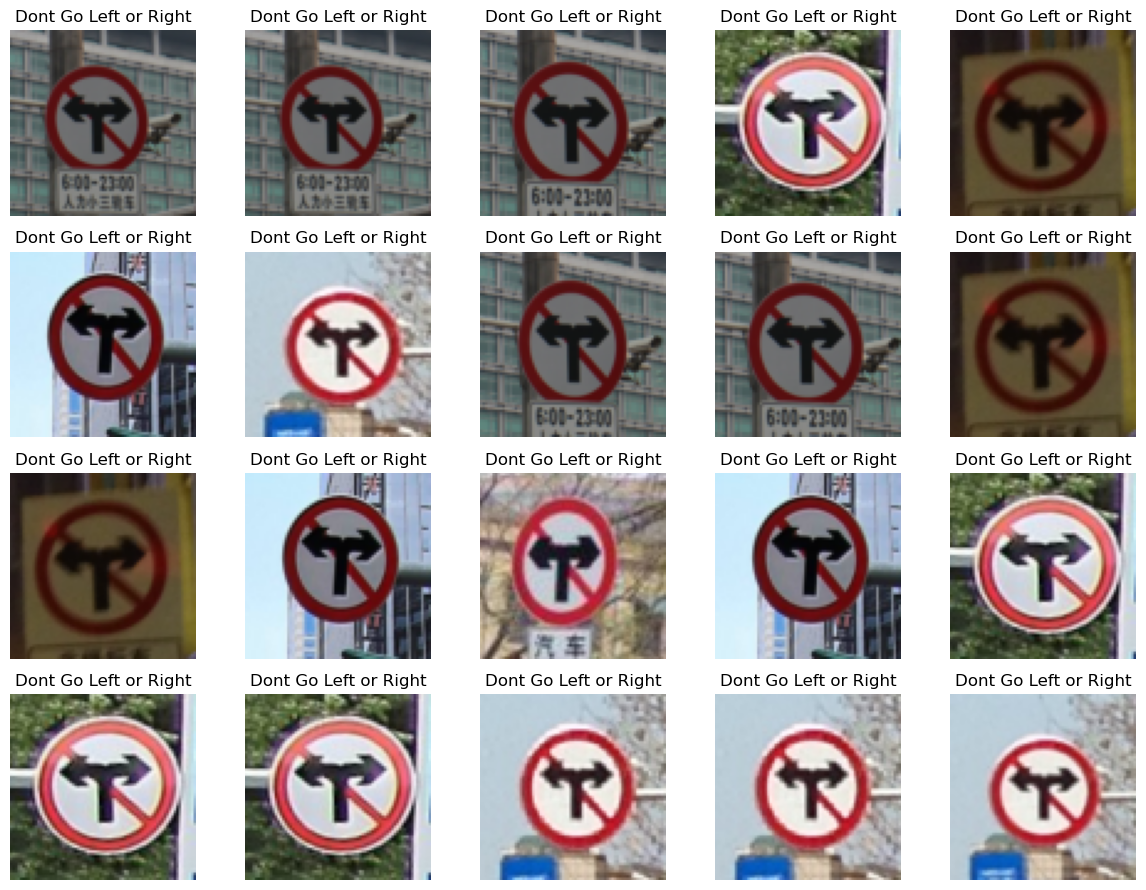

In [7]:
# Plotting Sample Training Images
fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(12, 9))
dataiter = iter(train_datagen)
idx = 0

for i in range(4):
    for j in range(5):
        images, l = next(dataiter)
        img = images
        label = the_real_labels[int(labels[l])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(img.permute(1,2,0))
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.show()

### **Preliminary Steps**

i - Check the range of values of the data set

In [8]:
def max_min_values(dataset, type=0):
    max_value = float('-inf')
    min_value = float('inf')

    for batch in dataset:
        if type==0:
            images, _ = batch
        else:
            images = batch
        max_batch = images.max()
        min_batch = images.min()
        if max_batch > max_value:
            max_value = max_batch
        if min_batch < min_value:
            min_value = min_batch
        
    print("Maximum pixel value:", max_value)
    print("Minimum pixel value:", min_value)

In [9]:
# Check if the dataset needs to be normalized
print("Train dataset")
max_min_values(train_datagen) # train
print("Test dataset")
max_min_values(test_dataset_loader_K,1) # test

Train dataset
Maximum pixel value: tensor(1.)
Minimum pixel value: tensor(0.)
Test dataset
Maximum pixel value: tensor(1.)
Minimum pixel value: tensor(0.)


ii - Visualization of the distribution of each class

In [10]:
# Plot random images from the dataset
def plot_images(x,y,half=False):
  labels = {0:'12',1:'13',2:'24',3:'37',4:'38',5:'39',6:'44',7:'50',8:'6'}
  
  fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(12, 9))
  
  for i in range(4):
    for j in range(5):
      ind = random.randint(0, np.size(x, 0)-1)
      img = x[ind]
      
      label = the_real_labels[int(labels[y[ind].item()])]
      img_shape = img.shape  # Get the shape of the image

      img = np.transpose(img, (1, 2, 0)) # Transpose dimensions to (height, width, channels)
      
      ax[i, j].set_title(f"{label}")
      ax[i, j].imshow(img)
      ax[i, j].axis("off")
  
  plt.tight_layout()
  plt.show()

In [11]:
def get_class_distribution(dataset, ind=1):
    
    labels = {0:'12',1:'13',2:'24',3:'37',4:'38',5:'39',6:'44',7:'50',8:'6'}
    
    if (ind == 1):
        count_dict = {k:0 for k,v in dataset.class_to_idx.items()} # initialise dictionary
    elif (ind == 2):
        count_dict = {k:0 for k in np.unique(dataset)}
        count_dict = {labels[k]: v for k, v in count_dict.items()} # Convert class indices to corresponding labels
    else:
        count_dict = {label: 0 for label in dataset.dataset.class_to_idx.values()}
    
    #print(count_dict)
    if(ind != 2):
        for input, label in dataset:
            if (ind == 1):
                count_dict[labels[label]] += 1
            else:
                count_dict[label] += 1
    else:
        for label in dataset:
            count_dict[labels[label]] += 1
        
    if (ind==0):
        # Convert class indices to corresponding labels
        count_dict = {labels[k]: v for k, v in count_dict.items()}
    
    print(count_dict)        
    return count_dict

In [12]:
def plot_distribution(dataset, ind=1):
    # visualize the  class distribution
    if(ind == 1):
        plt.figure(figsize=(5, 5))
        sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(dataset,ind)]).melt(), 
                    x = "variable", y="value", hue="variable").set_title('Class Distribution of the dataset')
    elif (ind == 2):
        plt.figure(figsize=(5, 5))
        sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(dataset,ind)]).melt(), 
                    x = "variable", y="value", hue="variable").set_title('Class Distribution of the dataset')
    else:
        fig, axes = plt.subplots(1, 3, figsize=(10, 5)) # Create subplots
        # Plot train set distribution
        sns.barplot(data=pd.DataFrame.from_dict([get_class_distribution(dataset[0],ind)]).melt(),
                    x="variable", y="value", hue="variable", ax=axes[0]).set_title('Train Set')
        
        # Plot validation set distribution
        sns.barplot(data=pd.DataFrame.from_dict([get_class_distribution(dataset[1],ind)]).melt(),
                    x="variable", y="value", hue="variable", ax=axes[1]).set_title('Validation Set')
        
        # Plot test set distribution
        sns.barplot(data=pd.DataFrame.from_dict([get_class_distribution(dataset[2],ind)]).melt(),
                    x="variable", y="value", hue="variable", ax=axes[2]).set_title('Test Set')
        
        plt.suptitle('Datasets Class Distributions')
        plt.tight_layout()
        plt.show()

{'12': 96, '13': 36, '24': 100, '37': 58, '38': 30, '39': 34, '44': 30, '50': 56, '6': 78}


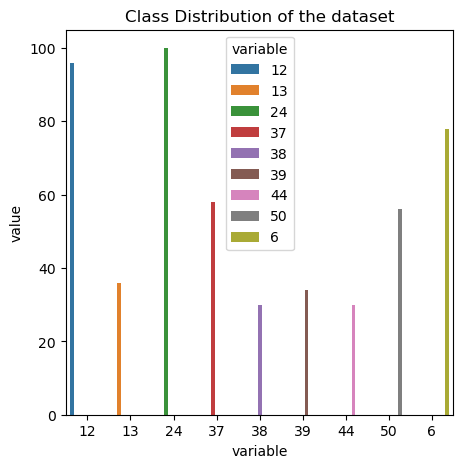

In [13]:
plot_distribution(train_datagen)

In [14]:
# We can see that the data is imbalanced in some classes there are lot of entries and in other there are little entries, that can lead to biased towards the majority class.

# Solutions: Data Augmentation (applying transformations in the images such as rotation, flipping, scaling and cropping)
#            Class Weighting (Giving different weights to the loss function, more weights to the minority classes)
#            Dropout / Undersampling or Oversampling
#            Ensemble Methods

In [15]:
# We can test 2 approaches to compare the results of the models
# Data Oversampling and Class Weighting

In [16]:
# Data Oversampling
def data_oversampling(X,y):
    # Instantiate the RandomOversampler
    ros = RandomOverSampler(random_state=42)

    # Resample the dataset
    X_res, y_res = ros.fit_resample(X, y)
    
    return X_res, y_res

In [17]:
# Class Weighting
def get_weights(y,debug=False):
    class_counts = torch.bincount(y.clone().detach()) # Count the number of samples in each class

    # Calculate the class weights
    total_samples = float(len(y))
    classes_weights = total_samples / (class_counts.float() + 1e-5)  # Add a small epsilon to avoid division by zero (if the class has zero samples)

    if debug:
        print(classes_weights)

    return classes_weights

iii -  Splitting the dataset into Train Validation Test sets

In [18]:
# Split the dataset in a 80/10/10 Ratio
train_size = int(0.8*len(train_datagen))
validation_size = int(0.1*len(train_datagen))
test_size = len(train_datagen) - train_size - validation_size

# Random_split
train_dataset, validation_dataset, test_dataset = random_split(train_datagen, [train_size,validation_size,test_size])

In [19]:
# Creating data loaders for train and validation
train_dataset_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_dataset_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataset_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

{'12': 75, '13': 28, '24': 84, '37': 39, '38': 21, '39': 29, '44': 28, '50': 49, '6': 61}
{'12': 6, '13': 6, '24': 13, '37': 7, '38': 2, '39': 3, '44': 1, '50': 4, '6': 9}
{'12': 15, '13': 2, '24': 3, '37': 12, '38': 7, '39': 2, '44': 1, '50': 3, '6': 8}


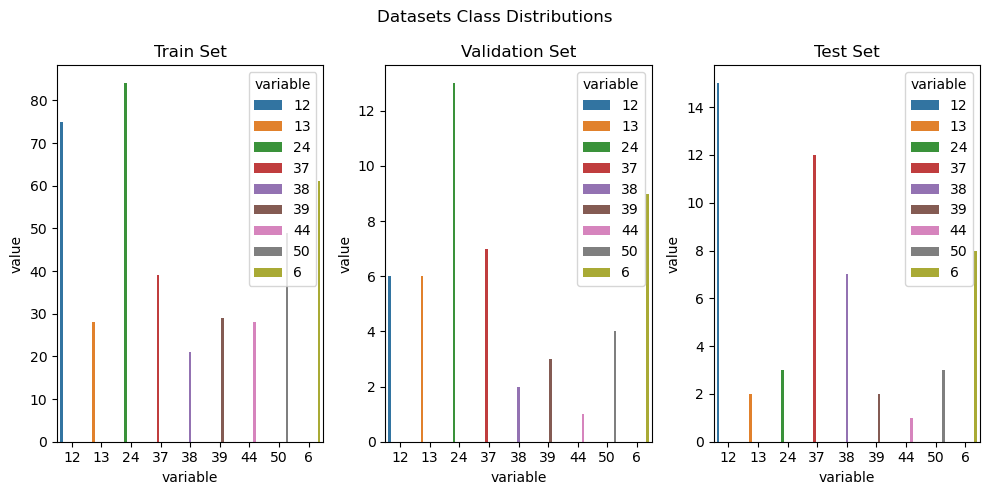

In [20]:
# Checks the distribution for each dataset
plot_distribution([train_dataset, validation_dataset, test_dataset], 0)

In [21]:
# Split the images from the labels in the dataset
def get_x_y(dataset):
    # list to store the images and labels
    x = []
    y = []

    # Iterate over the input to store them into X and Y
    for images, labels in dataset:
        x.append(images)
        y.append(labels)

    # Concatenate the list and transforms into a tensor
    x = torch.cat(x, dim=0)
    y = torch.cat(y, dim=0)

    return x, y

In [22]:
X_train, y_train = get_x_y(train_dataset_loader)
X_val, y_val = get_x_y(validation_dataset_loader)
X_test, y_test = get_x_y(test_dataset_loader)

In [23]:
# DATA OVERSAMPLING #
# flatten the image
X_train_fl = X_train.reshape(X_train.shape[0], -1) # Converts the 3D images to 1D vectors)

# Data Oversampling
X_train_data_ovs, y_train_data_ovs = data_oversampling(X_train_fl,y_train)

# Reshape the data
X_train_data_ovs = X_train_data_ovs.reshape(-1, 3, IMG_HEIGHT, IMG_WIDTH)  # Reshape to original format

print("Oversampling \n- Before:",len(X_train),"\n- After:", len(X_train_data_ovs))

Oversampling 
- Before: 414 
- After: 756


{'12': 84, '13': 84, '24': 84, '37': 84, '38': 84, '39': 84, '44': 84, '50': 84, '6': 84}


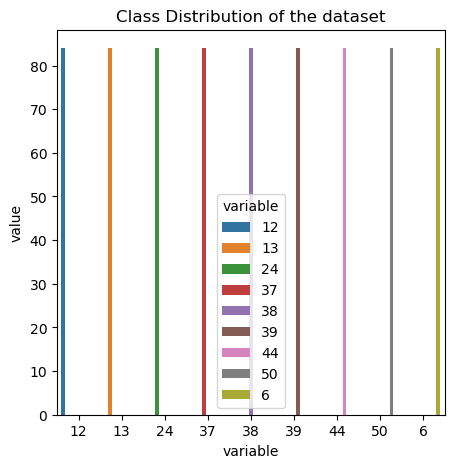

In [24]:
plot_distribution(y_train_data_ovs,2)

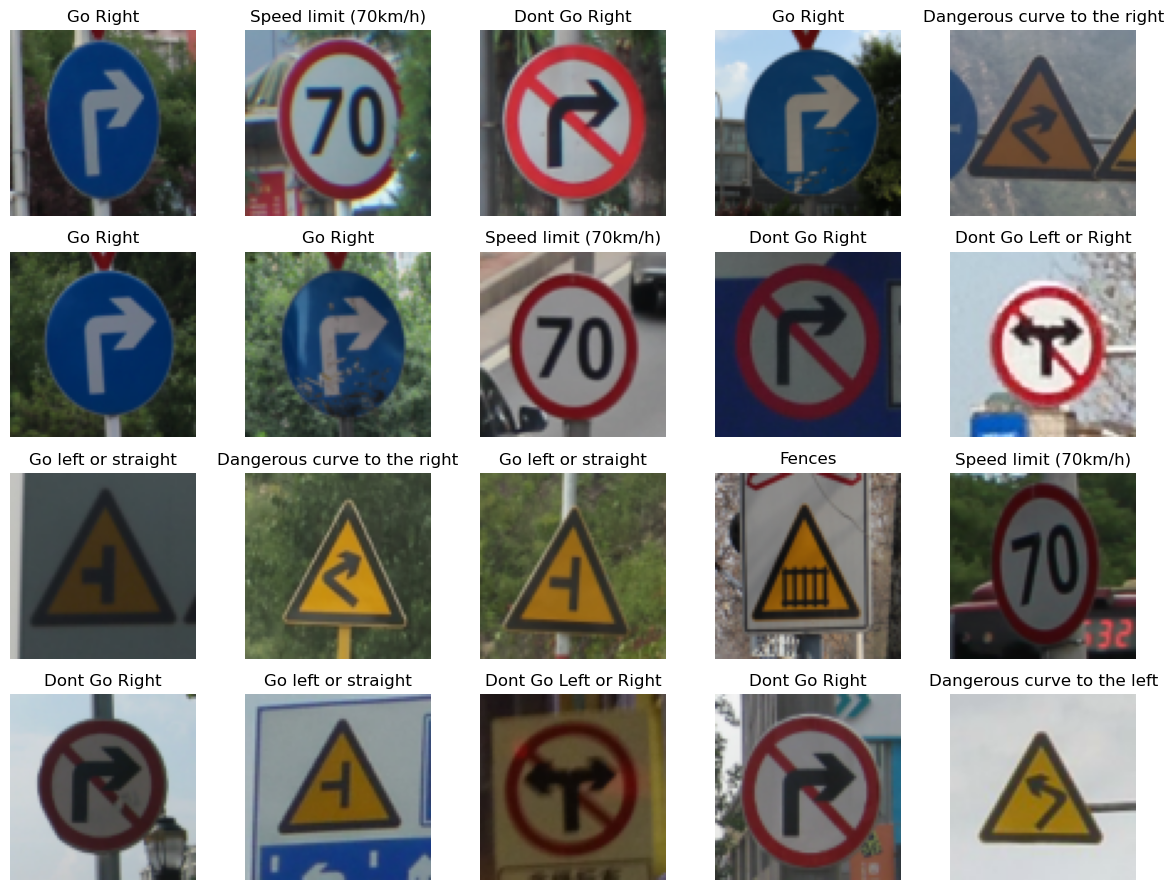

In [25]:
plot_images(X_train_data_ovs,y_train_data_ovs)

### **5. Models**

In [26]:
# Using manual seed to make sure that anyone who re-runs your code will get the exact same outputs. 
torch.manual_seed(42) 

In [27]:
# Check a better way to train the model instead of the CPU
if torch.backends.mps.is_available():
    device = torch.device("mps") # new macbooks
elif torch.cuda.is_available():    
    device = torch.device("cuda") # NVIDIA CUDA
else:
    device = torch.device("cpu")

###### **Model Evatuation Function** 

In [43]:
# accuracy is weak for unbalanced datasets
# overfitting you are remembering the cases of the training data instead of learning from it
def evaluate_network(net, X, y, to_device=True):
    # Set the model to evaluation mode
    net.eval()
    if to_device:
        X = X.to(device)
        net = net.to(device)

    # Run the model on the test data
    with torch.no_grad():
        outputs = net(X)
        _, predicted = torch.max(outputs.data, 1)

    # Convert tensors to numpy arrays
    if to_device:
        predicted = predicted.to("cpu")
    predicted_np = predicted.numpy()
    test_target_np = y.numpy()

    # Compute confusion matrix and F1 score
    conf_mat = confusion_matrix(test_target_np, predicted_np)
    f1 = f1_score(test_target_np, predicted_np, average='weighted')

    print('Confusion Matrix:\n', conf_mat)
    print('F1 Score: ', f1)

###### **Train Function** 

In [29]:
def fit(X_train, y_train, X_val, y_val, nn, criterion, optimizer, n_epochs, to_device=True, batch_size=32, ClassWeights=False, patience=5):
    #send everything to the device (ideally a GPU)
    if to_device:
        nn = nn.to(device)
        X_train = X_train.to(device)
        y_train = y_train.to(device)
        
    if(ClassWeights == True): # In the case of Class Weighting
        class_weights = get_weights(y_train)

    # Train the network
    train_loss_values = []
    val_loss_values = []
    
    # Variables to help with the early stopping
    best_val_loss = float('inf')   
    best_model = None              
    epochs_no_improve = 0          # No of epochs with no improvement

    
    for epoch in range(n_epochs):
        accu_loss = 0
        for i in range(0, X_train.size(0), batch_size): # the objective of the use of batch is to always improve the classifier in some sets of data
            X_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]

            # Forward pass
            outputs = nn(X_batch)
            loss = criterion(outputs, y_batch)
            
            if ClassWeights == True: # Manually apply class weights
                loss = torch.mean(loss * class_weights)
                
            accu_loss += loss.item()
            
            # Backward and optimize - to improve the weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        # Calculate the loss value for the validation set
        val_loss = 0
        nn.eval()
        for i in range(0, X_val.size(0), batch_size):
            X_batch = X_val[i:i+batch_size]
            y_batch = y_val[i:i+batch_size]
            
            # Forward pass
            outputs = nn(X_batch) 
            
            # Loss function
            loss = criterion(outputs, y_batch)
            
            # calculate loss
            val_loss += loss.item()
            
        # Check for early stopping
        if val_loss < best_val_loss: 
            best_val_loss = val_loss # updates the best value
            best_model = nn.state_dict() # save the current model weights
            epochs_no_improve = 0 # reset the counter
        else:
            epochs_no_improve += 1 # case of no improvement
        
        print ('Epoch [{}/{}], Train Loss: {:.4f}, Val Loss: {:.4f}'.format(epoch+1, n_epochs, accu_loss, val_loss))
           
        if epochs_no_improve >= patience: # if the patience value is reached, it stops the training
            print("Early stopping at epoch {}!".format(epoch + 1))
            break
            
        val_loss_values.append(val_loss)   
        train_loss_values.append(accu_loss)

    # Load the best model weights
    nn.load_state_dict(best_model)
    
    return [train_loss_values,val_loss_values], nn.to("cpu")

In [30]:
# Flatten the images #
# Train Dataset (With and Without Data Oversampling)
X_train_flattened_ovs = X_train_data_ovs.reshape(X_train_data_ovs.shape[0], -1) #Here we flatten the input 
print(type(X_train_flattened_ovs), X_train_flattened_ovs.shape)

X_train_flattened_ovs = torch.tensor(X_train_flattened_ovs, dtype=torch.float32)
y_train_fl_ovs = torch.tensor(y_train_data_ovs, dtype=torch.long)

X_train_flattened = X_train.reshape(X_train.shape[0], -1) 
print(type(X_train_flattened), X_train_flattened.shape)
 
y_train_fl = y_train.clone().detach()

# Validation Dataset
X_val_flattened = X_val.reshape(X_val.shape[0], -1)
y_val_fl = y_val.clone().detach()

<class 'numpy.ndarray'> (756, 16875)
<class 'torch.Tensor'> torch.Size([414, 16875])


In [31]:
# Class weights only for the training set
# Define the loss function with class weights
criterion_CrossEntropy_classWeight = nn.CrossEntropyLoss(weight=get_weights(y_train, True))
criterion_CrossEntropy = nn.CrossEntropyLoss()
criterion_MSE = nn.MSELoss()
criterion_KLD = nn.KLDivLoss()

tensor([ 5.5200, 14.7857,  4.9286, 10.6154, 19.7143, 14.2759, 14.7857,  8.4490,
         6.7869])


In [32]:
# Define the input variables for the models
n_epochs = 30
n_layers = 1
num_inputs_dos = X_train_flattened_ovs.shape[1]
num_inputs = X_train_flattened.shape[1]

num_classes = int(y_train.max().item() + 1)

# Determine the number of classes
hidden_layer_sizes_dos = ((num_inputs_dos + num_classes) // 2,)*n_layers
hidden_layer_sizes = ((num_inputs + num_classes) // 2,)*n_layers

In [33]:
def plot_loss_functions(loss_values,labels, title):    
    title = title + 'loss values'
    
    fig, axes = plt.subplots(1, 3, figsize=(10, 5)) # Create subplots
    # Plot train set distribution
    axes[0].plot(loss_values[0][0], label='Training Loss')
    axes[0].plot(loss_values[0][1], label='Validation Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title(labels[0])
    
    axes[1].plot(loss_values[1][0], label='Training Loss')
    axes[1].plot(loss_values[1][1], label='Validation Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].set_title(labels[1])
    
    axes[2].plot(loss_values[2][0], label='Training Loss')
    axes[2].plot(loss_values[2][1], label='Validation Loss')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Loss')
    axes[2].set_title(labels[2])
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.legend(loc="upper right")
    plt.show()    

In [34]:
def plot_loss_function(loss_values,labels):
    plt.plot(loss_values[0], label='Training Loss')
    plt.plot(loss_values[1], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(labels)
    
    plt.suptitle('MLP Loss Values')
    plt.tight_layout()
    plt.legend(loc="upper right")
    plt.show()

In [35]:
def train_val_model_ev_best_optmizer(model, num_inputs, hidden_layer_sizes, num_classes, X_train, y_train, X_val, y_val, criterion, optimizer, n_epochs, title):
    
    model_1 = model(input_size=num_inputs, hidden_sizes=hidden_layer_sizes, num_classes=num_classes)
    model_2 = model(input_size=num_inputs, hidden_sizes=hidden_layer_sizes, num_classes=num_classes)
    model_3 = model(input_size=num_inputs, hidden_sizes=hidden_layer_sizes, num_classes=num_classes)
    
    if optimizer == "RMSprop":
        optimizer1 = optim.RMSprop(model_1.parameters(), lr=0.1)
        optimizer2 = optim.RMSprop(model_2.parameters(), lr=0.01)
        optimizer3 = optim.RMSprop(model_3.parameters(), lr=0.001)
        labels= ['lr=0.1','lr=0.01','lr=0.001'] 
    elif optimizer == "Adam":
        optimizer1 = optim.Adam(model_1.parameters(), lr=0.1)
        optimizer2 = optim.Adam(model_2.parameters(), lr=0.01)
        optimizer3 = optim.Adam(model_3.parameters(), lr=0.001)
        labels= ['lr=0.1','lr=0.01','lr=0.001']
    elif optimizer == "SGD": 
        optimizer1 = optim.SGD(model_1.parameters(), lr=0.01, momentum=0.8)
        optimizer11 = optim.SGD(model_2.parameters(), lr=0.01, momentum=0.5)
        optimizer2 = optim.SGD(model_3.parameters(), lr=0.001, momentum=0.8)
        optimizer21 = optim.SGD(model.parameters(), lr=0.001, momentum=0.5)
        optimizer3 = optim.SGD(model.parameters(), lr=0.0001, momentum=0.8)
        optimizer31 = optim.SGD(model.parameters(), lr=0.0001, momentum=0.5)
        
    print(title,"w/ lr=0.1")
    loss_values_1, model_1 = fit(X_train, y_train, X_val, y_val, model_1, criterion, optimizer1, n_epochs, batch_size=BATCH_SIZE, to_device=False, patience=7)
    loss_values_1 = preprocessing.normalize(loss_values_1)
    
    print(title,"w/ lr=0.01")
    loss_values_2, model_2 = fit(X_train, y_train, X_val, y_val, model_2, criterion, optimizer2, n_epochs, batch_size=BATCH_SIZE, to_device=False, patience=7)
    loss_values_2 = preprocessing.normalize(loss_values_2)
    
    print(title,"w/ lr=0.001")
    loss_values_3, model_3 = fit(X_train, y_train, X_val, y_val, model_3, criterion, optimizer3, n_epochs, batch_size=BATCH_SIZE, to_device=False, patience=7)
    loss_values_3 = preprocessing.normalize(loss_values_3)
        
    plot_loss_functions([loss_values_1,loss_values_2,loss_values_3],labels,title)

In [36]:
def train_val_model_ev(model, num_inputs, hidden_layer_sizes, num_classes, X_train, y_train, X_val, y_val, criterion, optimizer, n_epochs, title, lr, m=0):
    model = model(input_size=num_inputs, hidden_sizes=hidden_layer_sizes, num_classes=num_classes)
     
    if optimizer == "RMSprop":
        optimizer_lr = optim.RMSprop(model.parameters(), lr=lr)
        
    elif optimizer == "Adam":
        optimizer_lr = optim.Adam(model.parameters(), lr=lr)
        
    elif optimizer == "SGD": 
        optimizer_lr = optim.SGD(model.parameters(), lr=lr, momentum=m)
        
    print(title,"w/ lr=", lr)
    loss_values, model = fit(X_train, y_train, X_val, y_val, model, criterion, optimizer_lr, n_epochs, batch_size=BATCH_SIZE, to_device=False, patience=7)
    loss_values = preprocessing.normalize(loss_values)
    labels= 'lr='+str(lr)
    
    plot_loss_function(loss_values,labels)
    
    print('Evaluating with the Training data')
    evaluate_network(model, X_train, y_train)
    
    print('Evaluating with the Validation data')
    evaluate_network(model, X_val, y_val)
    
    return model

##### **i - Multilayer Perceptron - MLP**

###### **Architecture**

In [37]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()
        self.activations = nn.ModuleList()

        if len(hidden_sizes) == 0:
            self.layers.append(nn.Linear(input_size, num_classes)) # no hidden layer
        else: # case that you have hidden 
            self.layers.append(nn.Linear(input_size, hidden_sizes[0]))
            self.activations.append(nn.ReLU())        
        
            for i in range(len(hidden_sizes)-1):
                self.layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
                self.activations.append(nn.ReLU())

            self.layers.append(nn.Linear(hidden_sizes[-1], num_classes)) # final hidden layer is linear
    
    def forward(self, x):    
        for i in range(len(self.layers)):
            x = self.layers[i](x)
            if i < len(self.activations): # if the layer have an activation function
                x = self.activations[i](x)
        return x

###### **Data Oversampling RMSprop and CrossEntropy**

RMSprop and CrossEntropy w/ lr=0.1
Epoch [1/30], Train Loss: 31655283.4784, Val Loss: 45507.4141
Epoch [2/30], Train Loss: 290593.1525, Val Loss: 8401.1704
Epoch [3/30], Train Loss: 25087.8224, Val Loss: 7258.9795
Epoch [4/30], Train Loss: 14114.7704, Val Loss: 2736.7020
Epoch [5/30], Train Loss: 3783.1432, Val Loss: 716.4377
Epoch [6/30], Train Loss: 479.8888, Val Loss: 0.8401
Epoch [7/30], Train Loss: 14.1034, Val Loss: 0.7391
Epoch [8/30], Train Loss: 12.9022, Val Loss: 0.6853
Epoch [9/30], Train Loss: 12.3473, Val Loss: 0.6577
Epoch [10/30], Train Loss: 12.0997, Val Loss: 0.6441
Epoch [11/30], Train Loss: 11.9818, Val Loss: 0.6373
Epoch [12/30], Train Loss: 11.9168, Val Loss: 0.6337
Epoch [13/30], Train Loss: 11.8758, Val Loss: 0.6318
Epoch [14/30], Train Loss: 11.8473, Val Loss: 0.6306
Epoch [15/30], Train Loss: 11.8262, Val Loss: 0.6299
Epoch [16/30], Train Loss: 11.8097, Val Loss: 0.6293
Epoch [17/30], Train Loss: 11.7964, Val Loss: 0.6290
Epoch [18/30], Train Loss: 11.7854, Val

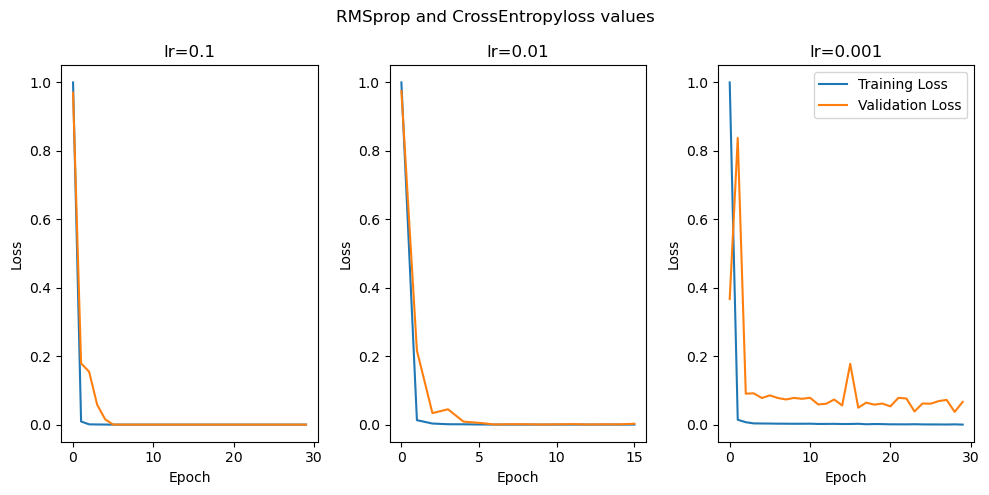

In [38]:
train_val_model_ev_best_optmizer(MLP, num_inputs_dos, hidden_layer_sizes_dos, num_classes, X_train_flattened_ovs, y_train_fl_ovs, X_val_flattened, y_val_fl, criterion_CrossEntropy, 'RMSprop', n_epochs, 'RMSprop and CrossEntropy')

In [ ]:
# the model with the learning rate 0.1 indicates a overfitting, the training loss decreases rapidly and the validation loss increases sharply.
# the model with the learning rate 0.01 has a better balance between learning and overfitting, the training loss decreases more gradually than the model with lr=0.01 and has a small increase in validation loss.
# the model with the learning rate 0.001 indicates potential underfitting, where the model might bit ve able to learn enough from the data.

In [ ]:
# for an additional exploration we can explore more learning rates near 0.01 (0.005 and 0.007) to find an optimal value that balances training and validation performance.
# Also for the lr = 0.001 whe can run the model with more epochs to see if it stabilizes the validation loss.

RMSprop and CrossEntropy w/ lr= 0.01
Epoch [1/30], Train Loss: 343809.9982, Val Loss: 192.3262
Epoch [2/30], Train Loss: 1766.8771, Val Loss: 523.9923
Epoch [3/30], Train Loss: 1046.7835, Val Loss: 36.2310
Epoch [4/30], Train Loss: 74.2630, Val Loss: 2.0894
Epoch [5/30], Train Loss: 21.2682, Val Loss: 2.3518
Epoch [6/30], Train Loss: 16.2936, Val Loss: 1.5171
Epoch [7/30], Train Loss: 14.2839, Val Loss: 0.9446
Epoch [8/30], Train Loss: 12.5938, Val Loss: 0.7617
Epoch [9/30], Train Loss: 11.5859, Val Loss: 0.7698
Epoch [10/30], Train Loss: 11.6776, Val Loss: 0.8307
Epoch [11/30], Train Loss: 12.4968, Val Loss: 1.5347
Epoch [12/30], Train Loss: 76.3129, Val Loss: 17.7893
Epoch [13/30], Train Loss: 77.4590, Val Loss: 7.4864
Epoch [14/30], Train Loss: 107.5411, Val Loss: 4.0906
Early stopping at epoch 15!


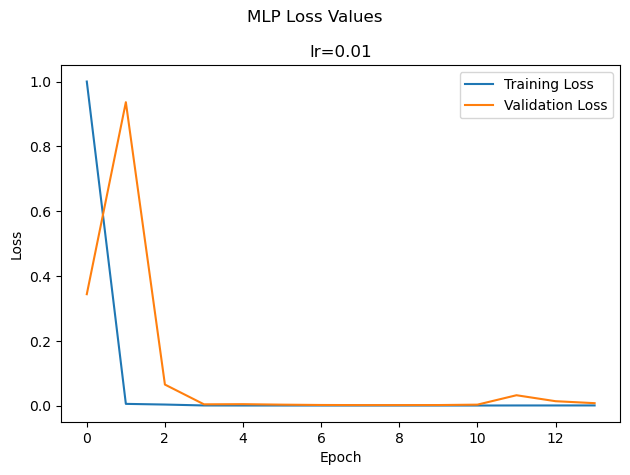

Evaluating with the Training data
Confusion Matrix:
 [[48  0  0  0 36  0  0  0  0]
 [ 0 84  0  0  0  0  0  0  0]
 [ 0  0 84  0  0  0  0  0  0]
 [ 2  0  0 43 39  0  0  0  0]
 [ 0  0  0  7 77  0  0  0  0]
 [ 0  0  0  0 81  0  3  0  0]
 [ 0  0  0  0 19  0 63  0  2]
 [ 0  0  0  0 84  0  0  0  0]
 [ 0  0  0  0  5  0  0  0 79]]
F1 Score:  0.6131264059973454
Evaluating with the Validation data
Confusion Matrix:
 [[ 1  0  0  0  5  0  0  0  0]
 [ 0  4  0  0  2  0  0  0  0]
 [ 0  0 13  0  0  0  0  0  0]
 [ 0  0  0  3  4  0  0  0  0]
 [ 0  0  0  0  2  0  0  0  0]
 [ 0  0  0  0  3  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  1]
 [ 0  0  0  0  4  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  9]]
F1 Score:  0.6392987817136425


In [44]:
# lr = 0.01
model_rms_ce_do = train_val_model_ev(MLP, num_inputs_dos, hidden_layer_sizes_dos, num_classes, X_train_flattened_ovs, y_train_fl_ovs, X_val_flattened, y_val_fl, criterion_CrossEntropy, 'RMSprop', n_epochs, 'RMSprop and CrossEntropy',0.01)

RMSprop and CrossEntropy w/ lr= 0.007
Epoch [1/30], Train Loss: 157687.4719, Val Loss: 130.6007
Epoch [2/30], Train Loss: 1114.7041, Val Loss: 29.4549
Epoch [3/30], Train Loss: 108.5877, Val Loss: 6.4090
Epoch [4/30], Train Loss: 23.8001, Val Loss: 1.0401
Epoch [5/30], Train Loss: 14.2357, Val Loss: 0.6952
Epoch [6/30], Train Loss: 12.7676, Val Loss: 0.8038
Epoch [7/30], Train Loss: 12.2437, Val Loss: 1.1331
Epoch [8/30], Train Loss: 17.0126, Val Loss: 4.5513
Epoch [9/30], Train Loss: 19.3212, Val Loss: 0.5819
Epoch [10/30], Train Loss: 14.7972, Val Loss: 3.4780
Epoch [11/30], Train Loss: 29.9569, Val Loss: 3.9396
Epoch [12/30], Train Loss: 20.9909, Val Loss: 3.2989
Epoch [13/30], Train Loss: 58.9378, Val Loss: 10.6536
Epoch [14/30], Train Loss: 36.9362, Val Loss: 2.4021
Epoch [15/30], Train Loss: 25.5384, Val Loss: 1.7656
Early stopping at epoch 16!


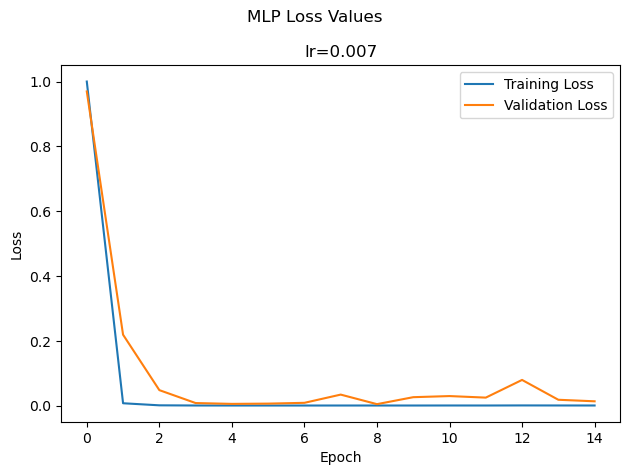

Evaluating with the Training data
Confusion Matrix:
 [[34  0  0  0 50  0  0  0  0]
 [ 0 84  0  0  0  0  0  0  0]
 [ 0  0 84  0  0  0  0  0  0]
 [ 0  0  0  0 34  8 42  0  0]
 [ 0  0  0  0 48 31  0  0  5]
 [ 0  0  0  0 76  8  0  0  0]
 [ 5  0  0  0 72  0  7  0  0]
 [ 0  0  0  0 32 44  0  8  0]
 [ 0  0  0  0  0  0  2  0 82]]
F1 Score:  0.458153268552827
Evaluating with the Validation data
Confusion Matrix:
 [[ 1  0  0  0  5  0  0  0  0]
 [ 0  4  0  0  2  0  0  0  0]
 [ 0  0 13  0  0  0  0  0  0]
 [ 0  0  0  0  2  0  5  0  0]
 [ 0  0  0  0  1  1  0  0  0]
 [ 0  0  0  0  2  1  0  0  0]
 [ 0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  1  3  0  0  0]
 [ 0  0  0  0  0  0  0  0  9]]
F1 Score:  0.5787114845938376


In [45]:
# lr = 0.007
model_rms_ce_do = train_val_model_ev(MLP, num_inputs_dos, hidden_layer_sizes_dos, num_classes, X_train_flattened_ovs, y_train_fl_ovs, X_val_flattened, y_val_fl, criterion_CrossEntropy, 'RMSprop', n_epochs, 'RMSprop and CrossEntropy',0.007)

RMSprop and CrossEntropy w/ lr= 0.005
Epoch [1/30], Train Loss: 92011.8178, Val Loss: 1099.3286
Epoch [2/30], Train Loss: 1585.7904, Val Loss: 17.1075
Epoch [3/30], Train Loss: 74.9909, Val Loss: 21.3831
Epoch [4/30], Train Loss: 69.4670, Val Loss: 13.2086
Epoch [5/30], Train Loss: 50.9467, Val Loss: 13.0580
Epoch [6/30], Train Loss: 65.6547, Val Loss: 17.0796
Epoch [7/30], Train Loss: 70.8564, Val Loss: 26.5676
Epoch [8/30], Train Loss: 54.1323, Val Loss: 5.7388
Epoch [9/30], Train Loss: 46.3388, Val Loss: 18.8266
Epoch [10/30], Train Loss: 36.2049, Val Loss: 2.6294
Epoch [11/30], Train Loss: 18.2439, Val Loss: 1.9411
Epoch [12/30], Train Loss: 20.2642, Val Loss: 44.5530
Epoch [13/30], Train Loss: 84.0997, Val Loss: 109.7208
Epoch [14/30], Train Loss: 100.0924, Val Loss: 2.6269
Epoch [15/30], Train Loss: 14.5637, Val Loss: 1.2052
Epoch [16/30], Train Loss: 12.9408, Val Loss: 1.0591
Epoch [17/30], Train Loss: 10.0192, Val Loss: 1.2301
Epoch [18/30], Train Loss: 15.2763, Val Loss: 1.706

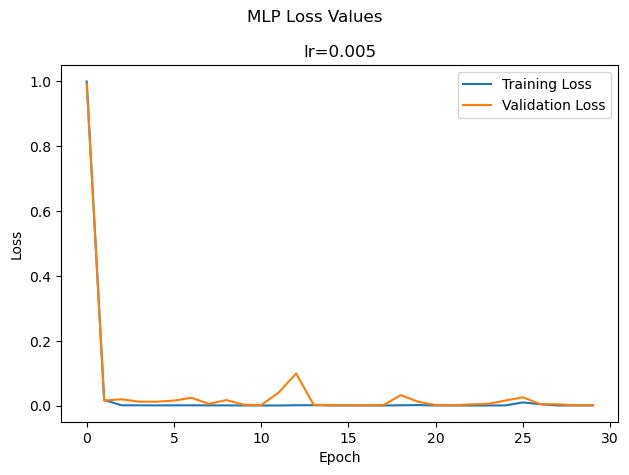

Evaluating with the Training data
Confusion Matrix:
 [[84  0  0  0  0  0  0  0  0]
 [ 0 82  0  0  0  0  0  0  2]
 [ 0  0 84  0  0  0  0  0  0]
 [ 0  0  0 46  5  5  0 28  0]
 [ 0  0  0  0  7  0 21 56  0]
 [ 0  0  0  0  0  6 30 48  0]
 [ 0  0  0  0  0  0 75  9  0]
 [ 0  0  0  0  0  0  0 84  0]
 [ 0  0  0  0  0  0  0  0 84]]
F1 Score:  0.6904448407244391
Evaluating with the Validation data
Confusion Matrix:
 [[ 6  0  0  0  0  0  0  0  0]
 [ 2  3  0  0  0  0  0  0  1]
 [ 0  0 13  0  0  0  0  0  0]
 [ 0  0  0  3  0  2  0  2  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  1  1  1  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  4  0]
 [ 0  0  0  0  0  0  0  0  9]]
F1 Score:  0.7682012517925831


In [46]:
# lr = 0.005
model_rms_ce_do = train_val_model_ev(MLP, num_inputs_dos, hidden_layer_sizes_dos, num_classes, X_train_flattened_ovs, y_train_fl_ovs, X_val_flattened, y_val_fl, criterion_CrossEntropy, 'RMSprop', n_epochs, 'RMSprop and CrossEntropy',0.005)

RMSprop and CrossEntropy w/ lr= 0.001
Epoch [1/50], Train Loss: 4860.4113, Val Loss: 57.4853
Epoch [2/50], Train Loss: 108.6751, Val Loss: 3.2561
Epoch [3/50], Train Loss: 25.3793, Val Loss: 3.4328
Epoch [4/50], Train Loss: 23.0331, Val Loss: 2.2450
Epoch [5/50], Train Loss: 18.7424, Val Loss: 3.0983
Epoch [6/50], Train Loss: 17.5315, Val Loss: 2.1197
Epoch [7/50], Train Loss: 14.7537, Val Loss: 2.0755
Epoch [8/50], Train Loss: 14.3993, Val Loss: 2.1370
Epoch [9/50], Train Loss: 13.7755, Val Loss: 2.3817
Epoch [10/50], Train Loss: 17.4946, Val Loss: 1.9154
Epoch [11/50], Train Loss: 12.2477, Val Loss: 1.8170
Epoch [12/50], Train Loss: 12.8536, Val Loss: 1.8875
Epoch [13/50], Train Loss: 11.8504, Val Loss: 2.7679
Epoch [14/50], Train Loss: 10.2679, Val Loss: 2.4077
Epoch [15/50], Train Loss: 10.5788, Val Loss: 2.3734
Epoch [16/50], Train Loss: 13.1340, Val Loss: 2.2033
Epoch [17/50], Train Loss: 14.1588, Val Loss: 2.5581
Early stopping at epoch 18!


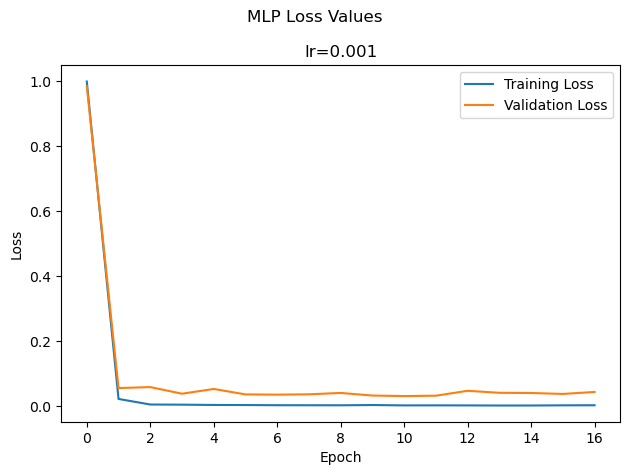

Evaluating with the Training data
Confusion Matrix:
 [[65  0  0  0  0  0 17  0  2]
 [ 0 29  0  0  0  0 32  0 23]
 [ 0  0 82  0  0  0  2  0  0]
 [ 0  0  0  0  0 30 21 33  0]
 [ 0  0  0  0  0  0 50 34  0]
 [ 0  0  0  0  0  0 34 50  0]
 [ 0  0  0  0  0  0 75  9  0]
 [ 0  0  0  0  0  0  0 84  0]
 [ 0  0  0  0  0  0  0  0 84]]
F1 Score:  0.4768660815390203
Evaluating with the Validation data
Confusion Matrix:
 [[ 6  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  2  0  4]
 [ 0  0 13  0  0  0  0  0  0]
 [ 0  0  0  0  0  2  3  2  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  2  1  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  4  0]
 [ 0  0  0  0  0  0  0  0  9]]
F1 Score:  0.5775401069518716


In [47]:
# lr = 0.001 with 50 epochs
model_rms_ce_do = train_val_model_ev(MLP, num_inputs_dos, hidden_layer_sizes_dos, num_classes, X_train_flattened_ovs, y_train_fl_ovs, X_val_flattened, y_val_fl, criterion_CrossEntropy, 'RMSprop', 50, 'RMSprop and CrossEntropy',0.001)

###### **Class Weighting RMSprop and CrossEntropy**

RMSprop and CrossEntropy w/ lr=0.1
Epoch [1/30], Train Loss: 58085120.6542, Val Loss: 219375.1797
Epoch [2/30], Train Loss: 1231701.1445, Val Loss: 34460.2100
Epoch [3/30], Train Loss: 134944.8999, Val Loss: 37925.5352
Epoch [4/30], Train Loss: 66795.9045, Val Loss: 8126.6414
Epoch [5/30], Train Loss: 37221.5443, Val Loss: 8971.7681
Epoch [6/30], Train Loss: 20983.8626, Val Loss: 1779.2127
Epoch [7/30], Train Loss: 14878.4132, Val Loss: 2439.2661
Epoch [8/30], Train Loss: 7478.9400, Val Loss: 1980.4451
Epoch [9/30], Train Loss: 5894.5036, Val Loss: 3316.2596
Epoch [10/30], Train Loss: 11856.8284, Val Loss: 3689.2095
Epoch [11/30], Train Loss: 19521.8541, Val Loss: 5651.1841
Epoch [12/30], Train Loss: 6754.1350, Val Loss: 3908.9823
Early stopping at epoch 13!
RMSprop and CrossEntropy w/ lr=0.01
Epoch [1/30], Train Loss: 576856.8611, Val Loss: 2064.6905
Epoch [2/30], Train Loss: 5651.9876, Val Loss: 31.9491
Epoch [3/30], Train Loss: 80.4432, Val Loss: 6.1737
Epoch [4/30], Train Loss: 18.

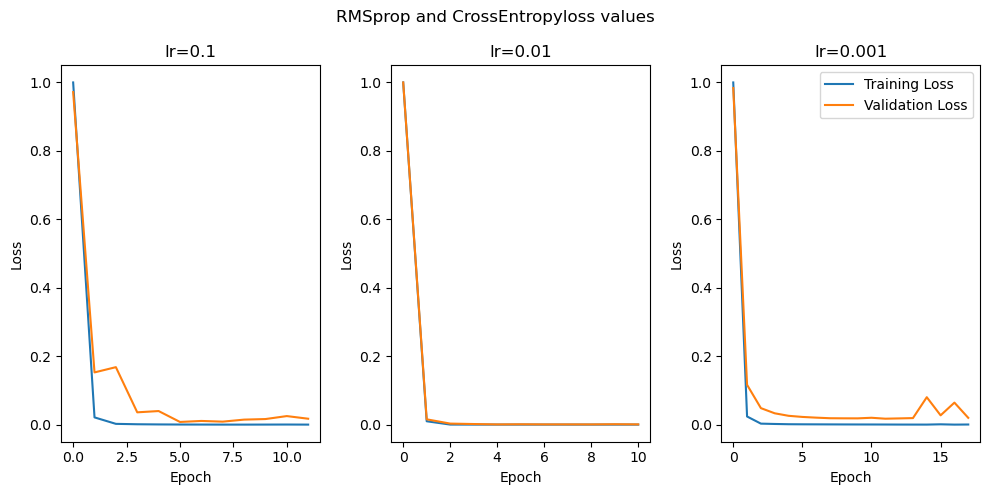

In [48]:
train_val_model_ev_best_optmizer(MLP, num_inputs, hidden_layer_sizes, num_classes, X_train_flattened, y_train_fl, X_val_flattened, y_val_fl, criterion_CrossEntropy_classWeight, 'RMSprop', n_epochs, 'RMSprop and CrossEntropy')

###### **Data Oversampling RMSprop and MSE**

In [ ]:
train_val_model_ev_best_optmizer(MLP, num_inputs_dos, hidden_layer_sizes_dos, num_classes, X_train_flattened_ovs, y_train_fl_ovs, X_val_flattened, y_val_fl, criterion_MSE, 'RMSprop', n_epochs, 'RMSprop and MSE')